In [1]:
# !pip install h5py
# !pip install keras
# !pip install tensorflow 

import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation, Dropout
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import adam_v2
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras.models import Model
import numpy as np
import tensorflow as tf
from keras.utils import np_utils
import os
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from pathlib import Path
from skimage import io
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# import Sequential from the keras models module
from keras.models import Sequential

# import Dense, Dropout, Flatten, Conv2D, MaxPooling2D from the keras layers module
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

In [9]:
%cd ..
%ls

G:\Shared drives\ML PROJECT\FP_Nehal_Anthony_Alex
 Volume in drive G is Google Drive
 Volume Serial Number is 1983-1116

 Directory of G:\Shared drives\ML PROJECT\FP_Nehal_Anthony_Alex

2022-04-26  03:33 PM    <DIR>          .
2022-04-26  03:26 PM    <DIR>          ..
2022-04-26  03:13 PM    <DIR>          EDA
2022-04-26  04:07 PM    <DIR>          Original_data
2022-04-26  04:04 PM    <DIR>          pseudo_resnet20
2022-04-26  03:31 PM                 0 Readme.txt
2022-04-26  04:16 PM    <DIR>          ResNet20
2022-04-26  04:07 PM    <DIR>          Resnet50
2022-04-26  04:09 PM    <DIR>          SVM
2022-04-26  04:05 PM    <DIR>          VanillaCNN
               1 File(s)              0 bytes
               9 Dir(s)  18,072,154,112 bytes free


In [2]:
batch_size = 20 
epochs = 100
num_classes = 2
depth = 20
subtract_pixel_mean = True

In [3]:
model_type = 'ResNet%d' % (depth)

In [10]:
# 2 Load image labels
# load labels.csv from datasets folder using pandas
labels = pd.read_csv('Original_data/dataset_alternate/labels_1.csv', index_col=0)

# print value counts for genus
print(labels.genus.value_counts())

# assign the genus label values to y
y = labels.genus.values

1.0    827
0.0    827
Name: genus, dtype: int64


Image has shape: (50, 50, 3)
RGB values for the top left pixel are: [127 108  95]


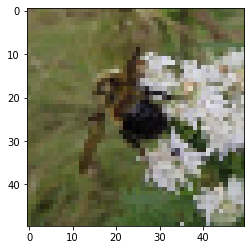

In [11]:
# 3. Examine RGB values in an image matrix
# load an image and explore
example_image = io.imread('Original_data\dataset_alternate\dataset_1/{}.jpg'.format(labels.index[0])) 

# show image
plt.imshow(example_image)

# print shape
print('Image has shape:', example_image.shape)

# print color channel values for top left pixel
print('RGB values for the top left pixel are:', example_image[0, 0, :])

In [12]:
# 4. Importing the image data
# create empty list
image_list = []

for i in labels.index:
    # load image
    img = io.imread('Original_data\dataset_alternate\dataset_1/{}.jpg'.format(i)).astype(np.float64)
        
    # append to list of all images
    image_list.append(img)
    
# convert image list to single array
X = np.array(image_list)

print(X.shape)

(1654, 50, 50, 3)


In [85]:
# 5 SPLITTING

# split remaining data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state=52)

# examine number of samples in train, test, and validation sets
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (1157, 50, 50, 3)
1157 train samples
497 test samples


In [87]:
input_shape = x_train.shape[1:]
input_shape

(50, 50, 3)

In [88]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [89]:
if subtract_pixel_mean:
  x_train_mean = np.mean(x_train, axis=0)
  x_train -= x_train_mean
  x_test -= x_train_mean

In [90]:
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (1157, 50, 50, 3)
y_train shape: (1157,)
1157 train samples
497 test samples


In [91]:
y_train = keras.utils.np_utils.to_categorical(y_train, num_classes)
y_test = keras.utils.np_utils.to_categorical(y_test, num_classes)

In [92]:
def lr_schedule(epoch):
  lr = 1e-3
  if epoch > 180:
      lr *= 0.5e-3
  elif epoch > 160:
      lr *= 1e-3
  elif epoch > 120:
      lr *= 1e-2
  elif epoch > 80:
      lr *= 1e-1
  print('Learning rate: ', lr)
  return lr

In [93]:
def resnet_layer(inputs, num_filters=16, kernel_size=3, strides=1, activation='relu', batch_normalization=True, conv_first=True):
  
  conv = Conv2D(num_filters, kernel_size=kernel_size, strides=strides, padding='same')

  x = inputs
  if conv_first:
      x = conv(x)
      if batch_normalization:
          x = BatchNormalization()(x)
      if activation is not None:
          x = Activation(activation)(x)
  else:
      if batch_normalization:
          x = BatchNormalization()(x)
      if activation is not None:
          x = Activation(activation)(x)
      x = conv(x)
  return x


In [94]:
def resnet_20(input_shape, depth, num_classes=2):
    
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,num_filters=num_filters,strides=strides)
            y = resnet_layer(inputs=y,num_filters=num_filters,activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,num_filters=num_filters,kernel_size=1,strides=strides,activation=None,batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
            x = Dropout(rate=0.25)(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes, activation='softmax')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


In [95]:
model = resnet_20(input_shape=input_shape, depth=depth)


In [96]:
model.compile(loss='binary_crossentropy',optimizer=adam_v2.Adam(lr=1e-3),metrics=['accuracy'])

Learning rate:  0.001


In [97]:
model.summary()
print(model_type)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 50, 50, 3)]  0           []                               
                                                                                                  
 conv2d_42 (Conv2D)             (None, 50, 50, 16)   448         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_38 (BatchN  (None, 50, 50, 16)  64          ['conv2d_42[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_38 (Activation)     (None, 50, 50, 16)   0           ['batch_normalization_38[0]

 add_21 (Add)                   (None, 25, 25, 32)   0           ['conv2d_51[0][0]',              
                                                                  'batch_normalization_46[0][0]'] 
                                                                                                  
 activation_46 (Activation)     (None, 25, 25, 32)   0           ['add_21[0][0]']                 
                                                                                                  
 dropout_21 (Dropout)           (None, 25, 25, 32)   0           ['activation_46[0][0]']          
                                                                                                  
 conv2d_52 (Conv2D)             (None, 25, 25, 32)   9248        ['dropout_21[0][0]']             
                                                                                                  
 batch_normalization_47 (BatchN  (None, 25, 25, 32)  128         ['conv2d_52[0][0]']              
 ormalizat

 dropout_25 (Dropout)           (None, 13, 13, 64)   0           ['activation_54[0][0]']          
                                                                                                  
 conv2d_61 (Conv2D)             (None, 13, 13, 64)   36928       ['dropout_25[0][0]']             
                                                                                                  
 batch_normalization_55 (BatchN  (None, 13, 13, 64)  256         ['conv2d_61[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 13, 13, 64)   0           ['batch_normalization_55[0][0]'] 
                                                                                                  
 conv2d_62 (Conv2D)             (None, 13, 13, 64)   36928       ['activation_55[0][0]']          
          

In [98]:
save_dir = os.path.join(os.getcwd(), 'saved_models_with_dropout')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

In [99]:
checkpoint = ModelCheckpoint(filepath=filepath,monitor='val_acc',verbose=1,save_best_only=True)

In [100]:
lr_scheduler = LearningRateScheduler(lr_schedule)

In [101]:
callbacks = [checkpoint, lr_scheduler]

In [76]:
tf.config.run_functions_eagerly(True)

In [103]:
history = model.fit(x_train, y_train,batch_size=batch_size,epochs=epochs,validation_data=(x_test, y_test),shuffle=True,callbacks=callbacks)

Learning rate:  0.001
Epoch 1/100
232/232 [==============================] - 61s 261ms/step - loss: 0.7296 - accuracy: 0.5324 - val_loss: 0.7549 - val_accuracy: 0.5171 - lr: 0.0010
Learning rate:  0.001
Epoch 2/100
232/232 [==============================] - 60s 257ms/step - loss: 0.6680 - accuracy: 0.6059 - val_loss: 0.6280 - val_accuracy: 0.6499 - lr: 0.0010
Learning rate:  0.001
Epoch 3/100
232/232 [==============================] - 60s 257ms/step - loss: 0.6150 - accuracy: 0.6724 - val_loss: 0.7065 - val_accuracy: 0.6016 - lr: 0.0010
Learning rate:  0.001
Epoch 4/100
232/232 [==============================] - 59s 256ms/step - loss: 0.5962 - accuracy: 0.6845 - val_loss: 0.5846 - val_accuracy: 0.6801 - lr: 0.0010
Learning rate:  0.001
Epoch 5/100
232/232 [==============================] - 61s 261ms/step - loss: 0.5607 - accuracy: 0.7252 - val_loss: 0.7053 - val_accuracy: 0.6922 - lr: 0.0010
Learning rate:  0.001
Epoch 6/100
232/232 [==============================] - 59s 256ms/step - l

Learning rate:  0.001
Epoch 25/100
232/232 [==============================] - 61s 263ms/step - loss: 0.3901 - accuracy: 0.8220 - val_loss: 0.8379 - val_accuracy: 0.7425 - lr: 0.0010
Learning rate:  0.001
Epoch 26/100
232/232 [==============================] - 60s 259ms/step - loss: 0.3813 - accuracy: 0.8323 - val_loss: 0.6985 - val_accuracy: 0.6861 - lr: 0.0010
Learning rate:  0.001
Epoch 27/100
232/232 [==============================] - 60s 260ms/step - loss: 0.3932 - accuracy: 0.8306 - val_loss: 0.6177 - val_accuracy: 0.6861 - lr: 0.0010
Learning rate:  0.001
Epoch 28/100
232/232 [==============================] - 60s 260ms/step - loss: 0.3941 - accuracy: 0.8332 - val_loss: 0.4519 - val_accuracy: 0.7887 - lr: 0.0010
Learning rate:  0.001
Epoch 29/100
232/232 [==============================] - 59s 256ms/step - loss: 0.3686 - accuracy: 0.8505 - val_loss: 0.5433 - val_accuracy: 0.7445 - lr: 0.0010
Learning rate:  0.001
Epoch 30/100
232/232 [==============================] - 59s 254ms/st

Learning rate:  0.001
Epoch 49/100
232/232 [==============================] - 60s 259ms/step - loss: 0.2802 - accuracy: 0.9015 - val_loss: 0.5831 - val_accuracy: 0.7626 - lr: 0.0010
Learning rate:  0.001
Epoch 50/100
232/232 [==============================] - 59s 256ms/step - loss: 0.2947 - accuracy: 0.8695 - val_loss: 0.5038 - val_accuracy: 0.7787 - lr: 0.0010
Learning rate:  0.001
Epoch 51/100
232/232 [==============================] - 60s 257ms/step - loss: 0.2563 - accuracy: 0.8971 - val_loss: 0.4073 - val_accuracy: 0.8149 - lr: 0.0010
Learning rate:  0.001
Epoch 52/100
232/232 [==============================] - 60s 259ms/step - loss: 0.2557 - accuracy: 0.8937 - val_loss: 0.7022 - val_accuracy: 0.6901 - lr: 0.0010
Learning rate:  0.001
Epoch 53/100
232/232 [==============================] - 59s 255ms/step - loss: 0.2704 - accuracy: 0.8920 - val_loss: 0.6647 - val_accuracy: 0.7203 - lr: 0.0010
Learning rate:  0.001
Epoch 54/100
232/232 [==============================] - 60s 257ms/st

Learning rate:  0.001
Epoch 73/100
232/232 [==============================] - 58s 251ms/step - loss: 0.2035 - accuracy: 0.9205 - val_loss: 0.5326 - val_accuracy: 0.7968 - lr: 0.0010
Learning rate:  0.001
Epoch 74/100
232/232 [==============================] - 58s 252ms/step - loss: 0.1872 - accuracy: 0.9274 - val_loss: 0.6409 - val_accuracy: 0.7586 - lr: 0.0010
Learning rate:  0.001
Epoch 75/100
232/232 [==============================] - 58s 250ms/step - loss: 0.1586 - accuracy: 0.9343 - val_loss: 0.4919 - val_accuracy: 0.7968 - lr: 0.0010
Learning rate:  0.001
Epoch 76/100
232/232 [==============================] - 60s 259ms/step - loss: 0.2030 - accuracy: 0.9162 - val_loss: 0.6685 - val_accuracy: 0.7606 - lr: 0.0010
Learning rate:  0.001
Epoch 77/100
232/232 [==============================] - 60s 257ms/step - loss: 0.1536 - accuracy: 0.9386 - val_loss: 0.7809 - val_accuracy: 0.7505 - lr: 0.0010
Learning rate:  0.001
Epoch 78/100
232/232 [==============================] - 60s 257ms/st

Learning rate:  0.0001
Epoch 97/100
232/232 [==============================] - 56s 242ms/step - loss: 0.0659 - accuracy: 0.9784 - val_loss: 0.6052 - val_accuracy: 0.7968 - lr: 1.0000e-04
Learning rate:  0.0001
Epoch 98/100
232/232 [==============================] - 57s 244ms/step - loss: 0.0722 - accuracy: 0.9697 - val_loss: 0.6052 - val_accuracy: 0.7968 - lr: 1.0000e-04
Learning rate:  0.0001
Epoch 99/100
232/232 [==============================] - 58s 249ms/step - loss: 0.0739 - accuracy: 0.9767 - val_loss: 0.6788 - val_accuracy: 0.7887 - lr: 1.0000e-04
Learning rate:  0.0001
Epoch 100/100
232/232 [==============================] - 57s 247ms/step - loss: 0.0650 - accuracy: 0.9775 - val_loss: 0.6741 - val_accuracy: 0.7847 - lr: 1.0000e-04


In [104]:
with open("./model.json", "w") as json_file:
  json_file.write(model.to_json())
  model.save_weights("./model_weights.h5")
  print("saved model to disk")

saved model to disk


In [105]:
loss, acc = model.evaluate(x_test, y_test)

16/16 [==============================] - 2s 117ms/step - loss: 0.6741 - accuracy: 0.7847


In [106]:
print("loss: ",loss,", Accuracy: ", acc)

loss:  0.6740607619285583 , Accuracy:  0.7847082614898682


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


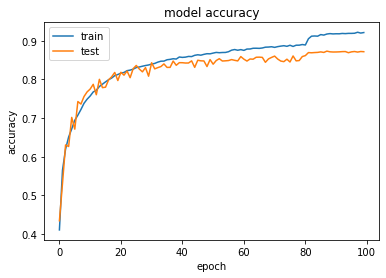

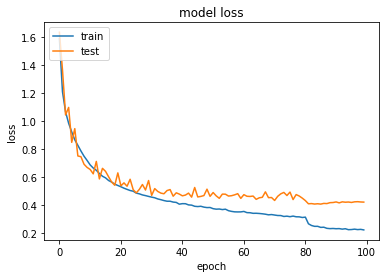

In [58]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [107]:
from keras.models import model_from_json

In [108]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model_weights.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = loaded_model.evaluate(x_test, y_test, verbose=0)
print('Testing '"%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

# evaluate loaded model on train data
score = loaded_model.evaluate(x_train, y_train, verbose=0)
print('Training '"%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))


Loaded model from disk
Testing accuracy: 78.47%
Training accuracy: 99.14%
